# Preamble

In [1]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
print(tensorflow.__version__)

1.15.0


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import numpy as np

from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_util
from tensorflow.python.ops import state_ops
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.training.tracking import data_structures
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export
from time import time

# ECNN classes

In [3]:
from tensorflow.python.keras.layers.recurrent import RNN,DropoutRNNCellMixin

## ECNNCell class

In [4]:
class ECNNCell(DropoutRNNCellMixin, Layer):
  """Cell class for ECNN.

  Arguments:
    units: Positive integer, dimensionality of the output space.
    activation: Activation function to use.
      Default: hyperbolic tangent (`tanh`).
      If you pass `None`, no activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix,
      used for the linear transformation of the inputs.
    recurrent_initializer: Initializer for the `recurrent_kernel`
      weights matrix, used for the linear transformation of the recurrent state.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to
      the `kernel` weights matrix.
    recurrent_regularizer: Regularizer function applied to
      the `recurrent_kernel` weights matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    kernel_constraint: Constraint function applied to
      the `kernel` weights matrix.
    recurrent_constraint: Constraint function applied to
      the `recurrent_kernel` weights matrix.
    bias_constraint: Constraint function applied to the bias vector.
    dropout: Float between 0 and 1.
      Fraction of the units to drop for
      the linear transformation of the inputs.
    recurrent_dropout: Float between 0 and 1.
      Fraction of the units to drop for
      the linear transformation of the recurrent state.

  Call arguments:
    inputs: A 2D tensor.
    states: List of state tensors corresponding to the previous timestep.
    training: Python boolean indicating whether the layer should behave in
      training mode or in inference mode. Only relevant when `dropout` or
      `recurrent_dropout` is used.
  """

  def __init__(self,
               units,
               activation='tanh',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    super(ECNNCell, self).__init__(**kwargs)
    self.units = units
    self.activation = activations.get(activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = self.units
    self.output_size = self.units

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    self.kernel = self.add_weight(
        shape=(input_shape[-1]-1, self.units),# remove the last column i.e. observed values
                                              # only used for the error computation
        name='kernel',
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint)
    
    self.D = self.add_weight(shape=(1, self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
    self.C = self.add_weight(shape=(self.units,1),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
    self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                      name='recurrent_kernel',
                                      initializer=self.recurrent_initializer,
                                      regularizer=self.recurrent_regularizer,
                                      constraint=self.recurrent_constraint)
    if self.use_bias:
      self.bias = self.add_weight(
          shape=(self.units,),
          name='bias',
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint)
    else:
      self.bias = None
    self.built = True

 

  def call(self, inputs, states, training=None):
    prev_output = states[0]
    dp_mask = self.get_dropout_mask_for_cell(inputs, training)
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        prev_output, training)
    obs= inputs[:,-1]         # only used for error computation but not in the training
    obs = K.expand_dims(obs,axis = 1)
    if dp_mask is not None:
      h = K.dot(inputs[:,:-1]* dp_mask, self.kernel) # observed values are not used in the training data
    else:
      h = K.dot(inputs[:,:-1], self.kernel)
    if self.bias is not None:
      h = K.bias_add(h, self.bias)

    if rec_dp_mask is not None:
      prev_output *= rec_dp_mask
    simple_rec = h + K.dot(prev_output, self.recurrent_kernel)
    Error = K.dot((K.tanh(K.dot(prev_output, self.C) - obs)),self.D)
    output = simple_rec + Error
    if self.activation is not None:
      output = self.activation(output)

    return output, [output]

  #def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
  #  return _generate_zero_filled_state_for_cell(self, inputs, batch_size, dtype)

  def get_config(self):
    config = {
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'recurrent_initializer':
            initializers.serialize(self.recurrent_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'recurrent_regularizer':
            regularizers.serialize(self.recurrent_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'recurrent_constraint':
            constraints.serialize(self.recurrent_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint),
        'dropout':
            self.dropout,
        'recurrent_dropout':
            self.recurrent_dropout
    }
    base_config = super(ECNNCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


## ECNN class

In [5]:
class ECNN(RNN):
  """Fully-connected RNN where the output is to be fed back to input.

  Arguments:
    units: Positive integer, dimensionality of the output space.
    activation: Activation function to use.
      Default: hyperbolic tangent (`tanh`).
      If you pass None, no activation is applied
      (ie. "linear" activation: `a(x) = x`).
    use_bias: Boolean, whether the layer uses a bias vector.
    kernel_initializer: Initializer for the `kernel` weights matrix,
      used for the linear transformation of the inputs.
    recurrent_initializer: Initializer for the `recurrent_kernel`
      weights matrix,
      used for the linear transformation of the recurrent state.
    bias_initializer: Initializer for the bias vector.
    kernel_regularizer: Regularizer function applied to
      the `kernel` weights matrix.
    recurrent_regularizer: Regularizer function applied to
      the `recurrent_kernel` weights matrix.
    bias_regularizer: Regularizer function applied to the bias vector.
    activity_regularizer: Regularizer function applied to
      the output of the layer (its "activation")..
    kernel_constraint: Constraint function applied to
      the `kernel` weights matrix.
    recurrent_constraint: Constraint function applied to
      the `recurrent_kernel` weights matrix.
    bias_constraint: Constraint function applied to the bias vector.
    dropout: Float between 0 and 1.
      Fraction of the units to drop for
      the linear transformation of the inputs.
    recurrent_dropout: Float between 0 and 1.
      Fraction of the units to drop for
      the linear transformation of the recurrent state.
    return_sequences: Boolean. Whether to return the last output
      in the output sequence, or the full sequence.
    return_state: Boolean. Whether to return the last state
      in addition to the output.
    go_backwards: Boolean (default False).
      If True, process the input sequence backwards and return the
      reversed sequence.
    stateful: Boolean (default False). If True, the last state
      for each sample at index i in a batch will be used as initial
      state for the sample of index i in the following batch.
    unroll: Boolean (default False).
      If True, the network will be unrolled,
      else a symbolic loop will be used.
      Unrolling can speed-up a RNN,
      although it tends to be more memory-intensive.
      Unrolling is only suitable for short sequences.

  Call arguments:
    inputs: A 3D tensor.
    mask: Binary tensor of shape `(samples, timesteps)` indicating whether
      a given timestep should be masked.
    training: Python boolean indicating whether the layer should behave in
      training mode or in inference mode. This argument is passed to the cell
      when calling it. This is only relevant if `dropout` or
      `recurrent_dropout` is used.
    initial_state: List of initial state tensors to be passed to the first
      call of the cell.
  """

  def __init__(self,
               units,
               activation='tanh',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               **kwargs):
    if 'implementation' in kwargs:
      kwargs.pop('implementation')
      logging.warning('The `implementation` argument '
                      'in `SimpleRNN` has been deprecated. '
                      'Please remove it from your layer call.')
    cell = ECNNCell(
        units,
        activation=activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        bias_initializer=bias_initializer,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout)
    super(ECNN, self).__init__(
        cell,
        return_sequences=return_sequences,
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll,
        **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)
    self.input_spec = [InputSpec(ndim=3)]

  def call(self, inputs, mask=None, training=None, initial_state=None):
    self.cell.reset_dropout_mask()
    self.cell.reset_recurrent_dropout_mask()
    return super(ECNN, self).call(
        inputs, mask=mask, training=training, initial_state=initial_state)

  @property
  def units(self):
    return self.cell.units

  @property
  def activation(self):
    return self.cell.activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  def get_config(self):
    config = {
        'units':
            self.units,
        'activation':
            activations.serialize(self.activation),
        'use_bias':
            self.use_bias,
        'kernel_initializer':
            initializers.serialize(self.kernel_initializer),
        'recurrent_initializer':
            initializers.serialize(self.recurrent_initializer),
        'bias_initializer':
            initializers.serialize(self.bias_initializer),
        'kernel_regularizer':
            regularizers.serialize(self.kernel_regularizer),
        'recurrent_regularizer':
            regularizers.serialize(self.recurrent_regularizer),
        'bias_regularizer':
            regularizers.serialize(self.bias_regularizer),
        'activity_regularizer':
            regularizers.serialize(self.activity_regularizer),
        'kernel_constraint':
            constraints.serialize(self.kernel_constraint),
        'recurrent_constraint':
            constraints.serialize(self.recurrent_constraint),
        'bias_constraint':
            constraints.serialize(self.bias_constraint),
        'dropout':
            self.dropout,
        'recurrent_dropout':
            self.recurrent_dropout
    }
    base_config = super(ECNN, self).get_config()
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    if 'implementation' in config:
      config.pop('implementation')
    return cls(**config)



# ECNN implementation example

## Preamble

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pylab as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [7]:
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model

In [8]:
from tensorflow.keras.layers import LSTM

## Hyper-parameter setting

In [9]:
Time_step  = 7
batch_size = 512
epochs     = 1000
neurons = 64
Features   = 6

## Model building

In [10]:
def my_model(neurons,bs,Time_step,epochs,Features=6):
    x1 = Input(batch_shape = (None,Time_step,Features))
    x2 = ECNN(neurons)(x1)
    x3 = Dense(1,activation='linear')(x2)
    return Model(x1,x3)

In [11]:
model = my_model(neurons,batch_size,Time_step,epochs)

W0619 13:55:23.836458 139959049545472 deprecation.py:506] From /home/kabuga/Documents/keras_tf/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 6)]            0         
_________________________________________________________________
ecnn (ECNN)                  (None, 64)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


## Data pre-processing

In [13]:
import pandas as pd

In [14]:
def ScaleData(df,normalise=True):
    if normalise:
        scaler = MinMaxScaler()# scaling data using minmaxscaler function from sklearn
        for i in list(df.columns.values):
            df[i] = scaler.fit_transform(df[i].values.reshape(-1, 1))
    return df, scaler

In [15]:
#data = "GDAXI.csv"

In [16]:
data = "path-of-stock-datafile" # Fetures : ['Date','Open','High','Low','Close','Adj Close','Volume']

In [17]:

dataP = pd.read_csv(data)
data_new = dataP.drop(["Date",'Volume'],axis=1) # Removing the Data and Volume columns
data_new = data_new.dropna()
Data, scaler = ScaleData(data_new)

### A column of observed values used to compute the error term is stacked next to features'columns

In [18]:
Data["Observed"]= Data["Close"]

In [19]:
values = Data.values

In [20]:
def SequenceToData(df, TimeStep):
    """Data formating into (nb samples, time step, features+1)
    where +1 is the observed value"""
    X,Y = [],[]
    for idx in range(len(df)):
        end_idx = idx+TimeStep
        if end_idx > len(df)-1:
            break
        seq_X, seq_Y = df[idx:end_idx], df[:,3][end_idx]
        X.append(seq_X)
        Y.append(seq_Y)
    return np.array(X), np.array(Y)

In [21]:
# D is the data and L are the true values to be estimated
D,L = SequenceToData(values,Time_step)

In [22]:
# checking the shape of the data. It has to be the length of the sequence-time_step-features+1
D.shape

(7070, 7, 6)

## Spliting the data into train, validation, and test sets

In [23]:
x_train, y_train = D[:5000],L[:5000]
x_valid, y_valid = D[5000:6000], L[5000:6000]
x_test, y_test   = D[6000:], L[6000:]

## Running model

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
model.compile(loss='mse', optimizer='adam')

In [26]:
callback = [tensorflow.keras.callbacks.ModelCheckpoint("mymodel.h5",monitor='val_loss',save_best_only=True,save_weights_only=True)]

In [27]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1, shuffle=False,
                   callbacks=callback)
model.load_weights('mymodel.h5')
print("validation loss = ", model.evaluate(x_valid,y_valid,verbose=1,batch_size = batch_size))

Train on 5000 samples, validate on 1070 samples
Epoch 1/1000
5000/5000 [==============================] - 0s 87us/sample - loss: 0.0038 - val_loss: 0.0062
Epoch 2/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 0.0018 - val_loss: 0.0068
Epoch 3/1000
5000/5000 [==============================] - 0s 14us/sample - loss: 0.0016 - val_loss: 0.0034
Epoch 4/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 0.0098 - val_loss: 0.0045
Epoch 5/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 0.0258 - val_loss: 0.0833
Epoch 6/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 0.0041 - val_loss: 0.0050
Epoch 7/1000
5000/5000 [==============================] - 0s 14us/sample - loss: 5.2845e-04 - val_loss: 0.0287
Epoch 8/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 1.7894e-04 - val_loss: 0.0199
Epoch 9/1000
5000/5000 [==============================] - 0s 14us/sample - loss: 1.2516e

5000/5000 [==============================] - 0s 11us/sample - loss: 5.2357e-05 - val_loss: 0.0046
Epoch 75/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 5.6721e-05 - val_loss: 0.0045
Epoch 76/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 6.4260e-05 - val_loss: 0.0044
Epoch 77/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 7.7841e-05 - val_loss: 0.0042
Epoch 78/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 1.0343e-04 - val_loss: 0.0041
Epoch 79/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 1.5385e-04 - val_loss: 0.0038
Epoch 80/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 2.5691e-04 - val_loss: 0.0035
Epoch 81/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 4.7037e-04 - val_loss: 0.0033
Epoch 82/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 8.9195e-04 - val_loss: 0.0032
Epoch 

Epoch 147/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.6192e-05 - val_loss: 0.0023
Epoch 148/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.6176e-05 - val_loss: 0.0022
Epoch 149/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.6161e-05 - val_loss: 0.0022
Epoch 150/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.6158e-05 - val_loss: 0.0022
Epoch 151/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.6173e-05 - val_loss: 0.0022
Epoch 152/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.6216e-05 - val_loss: 0.0022
Epoch 153/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.6299e-05 - val_loss: 0.0021
Epoch 154/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.6438e-05 - val_loss: 0.0021
Epoch 155/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.6659e-05 - 

5000/5000 [==============================] - 0s 11us/sample - loss: 3.5435e-05 - val_loss: 0.0012
Epoch 220/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.5476e-05 - val_loss: 0.0014
Epoch 221/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.6326e-05 - val_loss: 0.0014
Epoch 222/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.3886e-05 - val_loss: 0.0013
Epoch 223/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.2866e-05 - val_loss: 0.0012
Epoch 224/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.2777e-05 - val_loss: 0.0012
Epoch 225/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.2746e-05 - val_loss: 0.0012
Epoch 226/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.2745e-05 - val_loss: 0.0012
Epoch 227/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.2741e-05 - val_loss: 0.001

5000/5000 [==============================] - 0s 11us/sample - loss: 3.5637e-05 - val_loss: 6.9521e-04
Epoch 291/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.8001e-05 - val_loss: 6.7211e-04
Epoch 292/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 4.2074e-05 - val_loss: 6.4369e-04
Epoch 293/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 4.9331e-05 - val_loss: 6.0876e-04
Epoch 294/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 6.2633e-05 - val_loss: 5.6688e-04
Epoch 295/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 8.7444e-05 - val_loss: 5.2013e-04
Epoch 296/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 1.3339e-04 - val_loss: 4.7686e-04
Epoch 297/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 2.1362e-04 - val_loss: 4.5793e-04
Epoch 298/1000
5000/5000 [==============================] - 0s 11us/sample - lo

5000/5000 [==============================] - 0s 16us/sample - loss: 3.0791e-05 - val_loss: 5.0396e-04
Epoch 361/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0793e-05 - val_loss: 5.0120e-04
Epoch 362/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0797e-05 - val_loss: 4.9813e-04
Epoch 363/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0803e-05 - val_loss: 4.9489e-04
Epoch 364/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0812e-05 - val_loss: 4.9155e-04
Epoch 365/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0826e-05 - val_loss: 4.8812e-04
Epoch 366/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0847e-05 - val_loss: 4.8460e-04
Epoch 367/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0877e-05 - val_loss: 4.8094e-04
Epoch 368/1000
5000/5000 [==============================] - 0s 16us/sample - lo

5000/5000 [==============================] - 0s 18us/sample - loss: 2.3105e-04 - val_loss: 6.7458e-04
Epoch 431/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 7.7007e-05 - val_loss: 4.7427e-04
Epoch 432/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.2218e-05 - val_loss: 2.5673e-04
Epoch 433/1000
5000/5000 [==============================] - 0s 19us/sample - loss: 4.0788e-05 - val_loss: 1.9654e-04
Epoch 434/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.6602e-05 - val_loss: 2.2771e-04
Epoch 435/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.1187e-05 - val_loss: 2.9613e-04
Epoch 436/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0561e-05 - val_loss: 3.5265e-04
Epoch 437/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0863e-05 - val_loss: 3.7448e-04
Epoch 438/1000
5000/5000 [==============================] - 0s 16us/sample - lo

5000/5000 [==============================] - 0s 16us/sample - loss: 3.0426e-05 - val_loss: 2.7935e-04
Epoch 501/1000
5000/5000 [==============================] - 0s 18us/sample - loss: 3.0459e-05 - val_loss: 2.7797e-04
Epoch 502/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0504e-05 - val_loss: 2.7639e-04
Epoch 503/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0569e-05 - val_loss: 2.7455e-04
Epoch 504/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0662e-05 - val_loss: 2.7237e-04
Epoch 505/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0801e-05 - val_loss: 2.6975e-04
Epoch 506/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.1011e-05 - val_loss: 2.6655e-04
Epoch 507/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.1341e-05 - val_loss: 2.6257e-04
Epoch 508/1000
5000/5000 [==============================] - 0s 17us/sample - lo

5000/5000 [==============================] - 0s 18us/sample - loss: 3.0585e-05 - val_loss: 2.3413e-04
Epoch 571/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0771e-05 - val_loss: 2.5353e-04
Epoch 572/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0433e-05 - val_loss: 2.3112e-04
Epoch 573/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0443e-05 - val_loss: 2.4228e-04
Epoch 574/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0333e-05 - val_loss: 2.1805e-04
Epoch 575/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0409e-05 - val_loss: 2.4101e-04
Epoch 576/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.0355e-05 - val_loss: 2.1291e-04
Epoch 577/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.0489e-05 - val_loss: 2.4778e-04
Epoch 578/1000
5000/5000 [==============================] - 0s 17us/sample - lo

5000/5000 [==============================] - 0s 17us/sample - loss: 3.2763e-05 - val_loss: 2.6595e-04
Epoch 641/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.2715e-05 - val_loss: 3.8765e-04
Epoch 642/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.2186e-05 - val_loss: 2.6990e-04
Epoch 643/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.2153e-05 - val_loss: 3.7106e-04
Epoch 644/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.1736e-05 - val_loss: 2.7360e-04
Epoch 645/1000
5000/5000 [==============================] - 0s 18us/sample - loss: 3.1717e-05 - val_loss: 3.5545e-04
Epoch 646/1000
5000/5000 [==============================] - 0s 16us/sample - loss: 3.1402e-05 - val_loss: 2.7694e-04
Epoch 647/1000
5000/5000 [==============================] - 0s 17us/sample - loss: 3.1395e-05 - val_loss: 3.4106e-04
Epoch 648/1000
5000/5000 [==============================] - 0s 16us/sample - lo

5000/5000 [==============================] - 0s 12us/sample - loss: 3.0436e-05 - val_loss: 2.4391e-04
Epoch 711/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0432e-05 - val_loss: 2.4359e-04
Epoch 712/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0427e-05 - val_loss: 2.4329e-04
Epoch 713/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0423e-05 - val_loss: 2.4299e-04
Epoch 714/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0419e-05 - val_loss: 2.4270e-04
Epoch 715/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0415e-05 - val_loss: 2.4241e-04
Epoch 716/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0411e-05 - val_loss: 2.4214e-04
Epoch 717/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0406e-05 - val_loss: 2.4187e-04
Epoch 718/1000
5000/5000 [==============================] - 0s 12us/sample - lo

5000/5000 [==============================] - 0s 12us/sample - loss: 3.0255e-05 - val_loss: 2.3091e-04
Epoch 781/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0259e-05 - val_loss: 2.3061e-04
Epoch 782/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0266e-05 - val_loss: 2.3027e-04
Epoch 783/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0277e-05 - val_loss: 2.2989e-04
Epoch 784/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0293e-05 - val_loss: 2.2943e-04
Epoch 785/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0318e-05 - val_loss: 2.2889e-04
Epoch 786/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0358e-05 - val_loss: 2.2823e-04
Epoch 787/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0423e-05 - val_loss: 2.2741e-04
Epoch 788/1000
5000/5000 [==============================] - 0s 12us/sample - lo

5000/5000 [==============================] - 0s 12us/sample - loss: 3.2036e-05 - val_loss: 2.0964e-04
Epoch 851/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.3050e-05 - val_loss: 2.0673e-04
Epoch 852/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.4932e-05 - val_loss: 2.0363e-04
Epoch 853/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.8544e-05 - val_loss: 2.0109e-04
Epoch 854/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 4.5561e-05 - val_loss: 2.0162e-04
Epoch 855/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 5.8667e-05 - val_loss: 2.1226e-04
Epoch 856/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 7.9769e-05 - val_loss: 2.4877e-04
Epoch 857/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 1.0273e-04 - val_loss: 3.3030e-04
Epoch 858/1000
5000/5000 [==============================] - 0s 12us/sample - lo

5000/5000 [==============================] - 0s 12us/sample - loss: 3.0997e-05 - val_loss: 2.3617e-04
Epoch 921/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.1118e-05 - val_loss: 1.5830e-04
Epoch 922/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.2188e-05 - val_loss: 2.7172e-04
Epoch 923/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.2475e-05 - val_loss: 1.3992e-04
Epoch 924/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.5025e-05 - val_loss: 3.3324e-04
Epoch 925/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 3.6678e-05 - val_loss: 1.1901e-04
Epoch 926/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 4.1725e-05 - val_loss: 4.5089e-04
Epoch 927/1000
5000/5000 [==============================] - 0s 13us/sample - loss: 4.7289e-05 - val_loss: 1.0906e-04
Epoch 928/1000
5000/5000 [==============================] - 0s 11us/sample - lo

5000/5000 [==============================] - 0s 12us/sample - loss: 6.1045e-05 - val_loss: 1.8263e-04
Epoch 991/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 9.4620e-05 - val_loss: 2.4032e-04
Epoch 992/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 1.2976e-04 - val_loss: 3.6930e-04
Epoch 993/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 1.2854e-04 - val_loss: 5.3995e-04
Epoch 994/1000
5000/5000 [==============================] - 0s 11us/sample - loss: 7.7056e-05 - val_loss: 4.1032e-04
Epoch 995/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 4.5084e-05 - val_loss: 4.0221e-04
Epoch 996/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.0774e-05 - val_loss: 2.1131e-04
Epoch 997/1000
5000/5000 [==============================] - 0s 12us/sample - loss: 3.1107e-05 - val_loss: 2.3447e-04
Epoch 998/1000
5000/5000 [==============================] - 0s 12us/sample - lo

## Plotting training and validation error curves

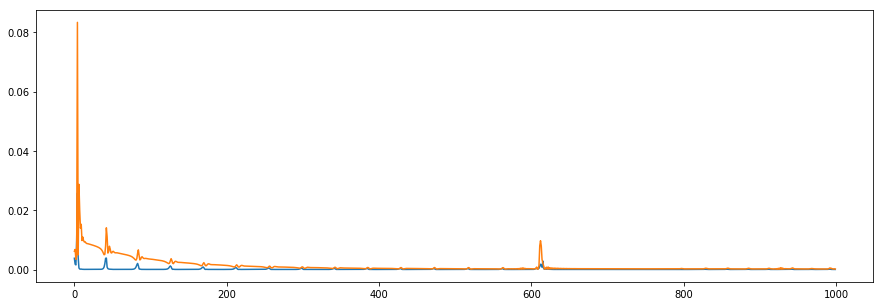

In [28]:
fig = plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Prediction on scaled data

In [29]:
pred_test = model.predict(x_test, batch_size=batch_size)
y_test=np.reshape(y_test, (y_test.shape[0],1))

## Visualization of real and predicted sequences on scaled data

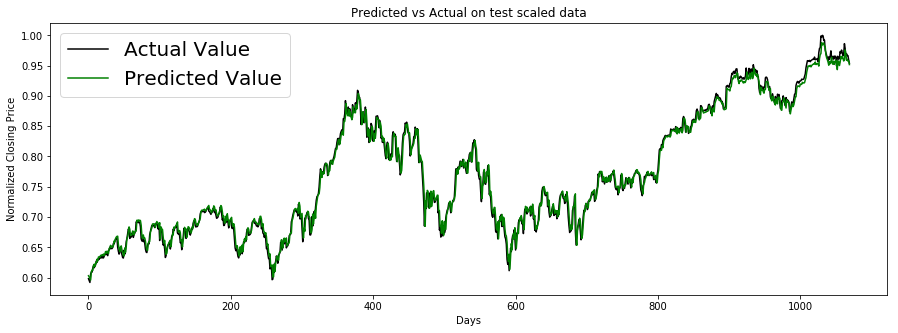

In [30]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color="black", label="Actual Value")
plt.plot(pred_test, color="green", label="Predicted Value")
plt.title('Predicted vs Actual on test scaled data')
plt.xlabel('Days')
plt.ylabel('Normalized Closing Price')
plt.legend(loc='best');
plt.legend(fontsize=20) 
plt.savefig("fi_NA_RW.pdf")
plt.show()

## Prediction on unscaled data

In [31]:
PRED_OR = scaler.inverse_transform(pred_test)
ACT_OR=scaler.inverse_transform(y_test)

## Visualization of real and predicted sequences on unscaled data

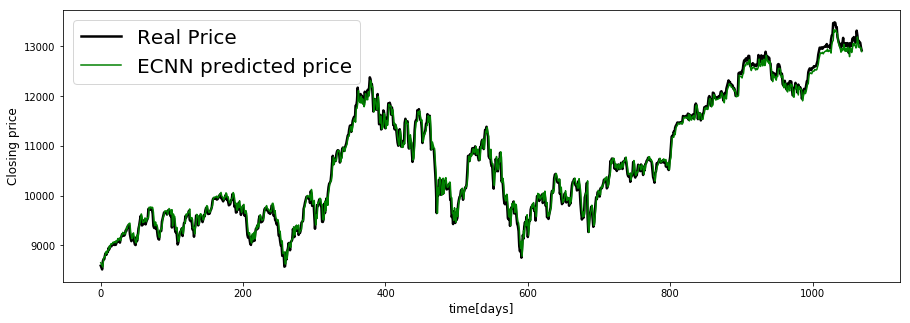

In [32]:
plt.figure(figsize=(15, 5));
plt.plot(ACT_OR, color="black", label="Real Price",linewidth=2.5)
plt.plot(PRED_OR, color="green", label="ECNN predicted price")
plt.xlabel('time[days]',fontsize="large")
plt.ylabel('Closing price', fontsize="large")
plt.legend(loc='best');
plt.legend(fontsize=20)
plt.show()

## Computation of the error: RMSE, MAE, R-Squared

In [33]:
print("RMSE = ",np.sqrt(mean_squared_error(y_test,pred_test)))
print("MAE",mean_absolute_error(y_test,pred_test))
print("R-squared = ", r2_score(y_test, pred_test))

RMSE =  0.010443350423176291
MAE 0.00783610815272718
R-squared =  0.9893532151023761
